In [2]:
!pip install fastapi
!pip install uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.4 MB/s eta 0:00:00


Dataset Head:
  Shipment ID     Origin Destination Shipment Date Planned Delivery Date  \
0  SHIP000000     Jaipur      Mumbai    2023-04-26            2023-05-01   
1  SHIP000001  Bangalore       Delhi    2023-02-09            2023-02-13   
2  SHIP000002     Mumbai     Chennai    2023-09-19            2023-09-25   
3  SHIP000003  Hyderabad   Ahmedabad    2023-04-01            2023-04-05   
4  SHIP000004    Chennai     Kolkata    2023-11-24            2023-11-26   

  Actual Delivery Date Vehicle Type  Distance (km) Weather Conditions  \
0           2023-05-02      Trailer           1603               Rain   
1           2023-02-17      Trailer           1237              Storm   
2           2023-09-25        Truck           1863              Clear   
3           2023-04-05    Container           1374              Clear   
4           2023-11-28    Container            676              Clear   

  Traffic Conditions Delayed  
0              Light     Yes  
1           Moderate     Yes

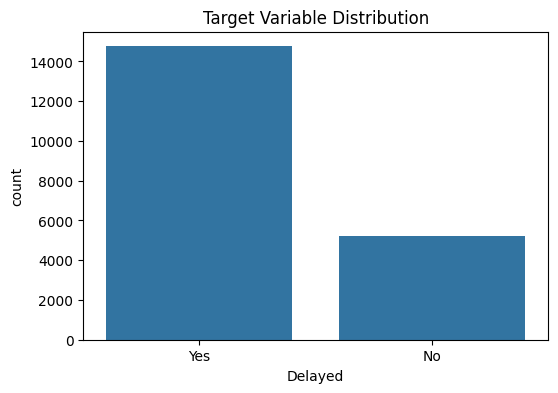

<ipython-input-5-fe2196509f6c>:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['Vehicle Type'].fillna(vehicle_type_mode, inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver o

Logistic Regression Performance:
Accuracy: 0.63
Precision: 0.70
Recall: 0.85
F1 Score: 0.77

Classification Report:

              precision    recall  f1-score   support

           0       0.01      0.00      0.01      1059
           1       0.70      0.85      0.77      2941

    accuracy                           0.63      4000
   macro avg       0.36      0.43      0.39      4000
weighted avg       0.52      0.63      0.57      4000


Random Forest Performance:
Accuracy: 0.91
Precision: 0.99
Recall: 0.88
F1 Score: 0.93

Classification Report:



INFO:     Started server process [250]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


              precision    recall  f1-score   support

           0       0.75      0.98      0.85      1059
           1       0.99      0.88      0.93      2941

    accuracy                           0.91      4000
   macro avg       0.87      0.93      0.89      4000
weighted avg       0.93      0.91      0.91      4000



INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [250]


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from fastapi import FastAPI
import nest_asyncio
import uvicorn
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data_path = "/content/AI ML Internship Training Data.xlsx"
data = pd.ExcelFile(data_path)
df = data.parse('freight_delivery_realistic_data')

#  EDA
print("Dataset Head:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

# Distribution of Target Variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Delayed', data=df)
plt.title("Target Variable Distribution")
plt.show()

# Data cleaning and preprocessing
df_cleaned = df.drop(columns=['Shipment ID', 'Planned Delivery Date', 'Actual Delivery Date'])

# Handle missing values in Vehicle Type
vehicle_type_mode = df_cleaned['Vehicle Type'].mode()[0]
df_cleaned['Vehicle Type'].fillna(vehicle_type_mode, inplace=True)

# Encode categorical variables
categorical_cols = ['Origin', 'Destination', 'Vehicle Type', 'Weather Conditions', 'Traffic Conditions', 'Delayed']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

# Extract additional features from the Shipment Date
df_cleaned['Shipment Month'] = df_cleaned['Shipment Date'].dt.month
df_cleaned['Shipment Day'] = df_cleaned['Shipment Date'].dt.day
df_cleaned = df_cleaned.drop(columns=['Shipment Date'])  # Drop the original datetime column

# Split data into features and target
X = df_cleaned.drop(columns=['Delayed'])
y = df_cleaned['Delayed']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

print("Logistic Regression Performance:")
evaluate_model(logistic_model, X_test, y_test)

print("\nRandom Forest Performance:")
evaluate_model(rf_model, X_test, y_test)

# Deployment using FastAPI
app = FastAPI()

@app.post("/predict")
def predict_delay(
    origin: str, destination: str, vehicle_type: str, distance: int,
    weather: str, traffic: str
):
    # Prepare input data
    input_data = pd.DataFrame({
        'Origin': [label_encoders['Origin'].transform([origin])[0]],
        'Destination': [label_encoders['Destination'].transform([destination])[0]],
        'Vehicle Type': [label_encoders['Vehicle Type'].transform([vehicle_type])[0]],
        'Distance (km)': [distance],
        'Weather Conditions': [label_encoders['Weather Conditions'].transform([weather])[0]],
        'Traffic Conditions': [label_encoders['Traffic Conditions'].transform([traffic])[0]]
    })

    # Make prediction using the better model (Random Forest)
    prediction = rf_model.predict(input_data)
    result = label_encoders['Delayed'].inverse_transform(prediction)[0]
    return {"Delayed": result}

nest_asyncio.apply()

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)
